In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
from glob import glob
from config import constants

In [3]:
IS_BINARY = False

params = {
    'batch_size': 16,
    'n_d': 32,
    'n_a': 32,
    'n_steps': 5,
    'gamma': 1.2,
    'n_independent': 2,
    'n_shared': 3,
    'epochs': 10,
    'learning_rate': 0.001,
}

In [4]:
CATEGORIES = constants.CATEGORIES
PLOTS_DIR = './images'
MODEL_PATH = './models'
if IS_BINARY:
    DATASET_PATH = 'datasets/data/benign_or_attack_merged'
else:
    DATASET_PATH = 'datasets/data/different_features'

In [5]:
csv_files = glob(os.path.join(DATASET_PATH, "*.csv"))
print(f"IS_BINARY: { IS_BINARY } \n{ csv_files }")

IS_BINARY: False 
['datasets/data/different_features\\traffic_features.csv']


In [6]:
data_frames = []

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file, delimiter=',')
        print(f"Файл {csv_file}: {df.shape[0]} строк, {df.shape[1]} столбцов")
        data_frames.append(df)
    except Exception as e:
        print(f"Ошибка при чтении {csv_file}: {e}")

if not data_frames:
    raise ValueError("Не удалось прочитать ни один CSV-файл.")

Файл datasets/data/different_features\traffic_features.csv: 1223 строк, 78 столбцов


In [7]:
data = pd.concat(data_frames, ignore_index=True)
print(f"Объединённый DataFrame из {len(csv_files)} файла: {data.shape[0]} строк, {data.shape[1]} столбцов")

Объединённый DataFrame из 1 файла: 1223 строк, 78 столбцов


In [8]:
data = data.dropna()
data = data.fillna(0).replace([np.inf, -np.inf], 0)
data.columns = data.columns.str.strip()

In [9]:
print(data.shape)

(1223, 78)


In [10]:
data['Label'].unique()

array(['cloud_service', 'e-mail', 'games', 'information', 'music',
       'social_network', 'video_hosting'], dtype=object)

In [11]:
print("\nАнализ распределения классов:")
class_counts = pd.Series(data['Label']).value_counts()
class_percentages = pd.Series(data['Label']).value_counts(normalize=True) * 100
distribution_df = pd.DataFrame({
    'Количество': class_counts,
    'Процент': class_percentages.round(2)
}).sort_index()

print(distribution_df)


Анализ распределения классов:
                Количество  Процент
Label                              
cloud_service          103     8.42
e-mail                  99     8.09
games                  432    35.32
information            170    13.90
music                  140    11.45
social_network         172    14.06
video_hosting          107     8.75


In [17]:
X = data.drop('Label', axis=1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Label'])
class_names = label_encoder.classes_


for i in range(0, len(class_names)):
    print(f"{np.unique(y)[i]}: {class_names[i]}")

0: cloud_service
1: e-mail
2: games
3: information
4: music
5: social_network
6: video_hosting


In [18]:
feature_names = X.columns
print(feature_names)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

In [22]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

In [18]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=params.get('batch_size'), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=params.get('batch_size'), shuffle=False)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
class TabNet(nn.Module):
    def __init__(self, input_dim, output_dim, n_d=32, n_a=32, n_steps=3, gamma=1.3,
                 n_independent=2, n_shared=2, momentum=0.02):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.momentum = momentum

        self.initial_bn = nn.BatchNorm1d(input_dim, momentum=momentum)
        self.initial_splitter = FeatureTransformer(input_dim, n_d + n_a, n_independent, n_shared, momentum)
        self.attentive_transformers = nn.ModuleList([
            AttentiveTransformer(input_dim, n_a, momentum) for _ in range(n_steps)  # Используем n_a вместо n_d + n_a
        ])
        self.feature_transformers = nn.ModuleList([
            FeatureTransformer(input_dim, n_d + n_a, n_independent, n_shared, momentum)
            for _ in range(n_steps)
        ])
        self.final_linear = nn.Linear(n_d, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.initial_bn(x)
        prior = torch.ones(batch_size, self.input_dim, device=x.device)
        M_loss = 0
        outputs = []
        M = []

        features = self.initial_splitter(x)
        d, a = features[:, :self.n_d], features[:, self.n_d:]

        for step in range(self.n_steps):
            M_i = self.attentive_transformers[step](a, prior)
            M.append(M_i)
            M_loss += torch.mean(torch.sum(-M_i * torch.log(M_i + 1e-15), dim=1))
            prior = self.gamma - M_i
            prior = torch.cumprod(prior, dim=0)
            masked_x = M_i * x
            features = self.feature_transformers[step](masked_x)
            d, a = features[:, :self.n_d], features[:, self.n_d:]
            outputs.append(d)

        out = torch.stack(outputs, dim=1).sum(dim=1)
        out = self.final_linear(out)
        return out, M, M_loss / self.n_steps

In [21]:
class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, n_independent, n_shared, momentum):
        super(FeatureTransformer, self).__init__()
        self.shared = nn.ModuleList()
        for i in range(n_shared):
            in_features = input_dim if i == 0 else output_dim
            self.shared.append(nn.Sequential(
                nn.Linear(in_features, output_dim * 2),
                nn.BatchNorm1d(output_dim * 2, momentum=momentum),
                nn.GLU()
            ))
        self.independent = nn.ModuleList()
        for _ in range(n_independent):
            self.independent.append(nn.Sequential(
                nn.Linear(output_dim, output_dim * 2),
                nn.BatchNorm1d(output_dim * 2, momentum=momentum),
                nn.GLU()
            ))

    def forward(self, x):
        shared_out = x
        for layer in self.shared:
            shared_out = layer(shared_out)
        out = shared_out
        for layer in self.independent:
            out = layer(out)
        return out

In [22]:
class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim, n_a, momentum):
        super(AttentiveTransformer, self).__init__()
        self.fc = nn.Linear(n_a, input_dim)
        self.bn = nn.BatchNorm1d(input_dim, momentum=momentum)

    def forward(self, a, prior):
        a = self.fc(a)
        a = self.bn(a)
        a = a * prior
        return sparsemax(a)

In [23]:
def sparsemax(x):
    """Sparsemax function for attention mechanism"""
    sorted_x, _ = torch.sort(x, dim=1, descending=True)
    cumsum = torch.cumsum(F.softmax(sorted_x, dim=1), dim=1)
    rho = (cumsum <= 1).sum(dim=1, keepdim=True)
    tau = (cumsum.gather(1, rho - 1) - 1) / rho
    out = F.relu(x - tau)
    return out / (out.sum(dim=1, keepdim=True) + 1e-15)

In [24]:
def train_tabnet(model, train_loader, test_loader, optimizer, epochs, device, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        model.train()

        # Прогресс-бар для батчей
        train_pbar = tqdm(train_loader, desc=f'Эпоха {epoch+1}/{epochs}', leave=True)
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output, M, M_loss = model(data)
            loss = criterion(output, target) + 0.01 * M_loss
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            pred = output.argmax(dim=1)
            total_train_correct += pred.eq(target).sum().item()
            total_train_samples += target.size(0)

            # Вычисление текущей точности и потерь для батча
            batch_loss = loss.item()
            batch_accuracy = 100. * pred.eq(target).sum().item() / target.size(0)

            # Обновление прогресс-бара с информацией
            train_pbar.set_postfix({
                'Batch Loss': f'{batch_loss:.4f}',
                'Batch Acc': f'{batch_accuracy:.2f}%'
            })

        # Итоговые метрики на тренировочном наборе
        train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100. * total_train_correct / total_train_samples
        train_losses.append(train_loss)

        # Оценка на тестовом наборе
        model.eval()
        total_test_loss = 0
        total_test_correct = 0
        total_test_samples = 0
        y_pred = []
        y_true = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output, _, M_loss = model(data)
                test_loss = criterion(output, target) + 0.01 * M_loss
                total_test_loss += test_loss.item()
                pred = output.argmax(dim=1)
                total_test_correct += pred.eq(target).sum().item()
                total_test_samples += target.size(0)
                y_pred.extend(pred.cpu().numpy())
                y_true.extend(target.cpu().numpy())

        test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100. * total_test_correct / total_test_samples
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary' if IS_BINARY else 'weighted', zero_division=0
        )

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Вывод итоговых метрик для эпохи
        print(f'\nЭпоха {epoch+1}/{epochs}:')
        print(f'  Тренировочные потери: {train_loss:.4f}, Тренировочная точность: {train_accuracy:.2f}%')
        print(f'  Тестовые потери: {test_loss:.4f}, Тестовая точность: {test_accuracy:.2f}%')
        print(f'  Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n')

    return train_losses, test_losses, test_accuracies

In [25]:
def get_feature_importance(model, data_loader, device, feature_names):
    model.eval()
    feature_importance = torch.zeros(model.input_dim).to(device)
    total_samples = 0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            _, masks, _ = model(data)
            for mask in masks:
                feature_importance += mask.sum(dim=0)
            total_samples += data.size(0)
    importance = feature_importance.cpu().numpy() / total_samples

    return pd.Series(importance, index=feature_names)

In [26]:
def evaluate_model(model, test_loader, device, is_binary):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    y_pred = []
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _, M_loss = model(data)
            loss = criterion(output, target) + 0.01 * M_loss
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(target.cpu().numpy())
            if is_binary:
                scores = torch.softmax(output, dim=1)[:, 1]
                y_scores.extend(scores.cpu().numpy())

    test_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary' if is_binary else 'weighted')
    cm = confusion_matrix(y_true, y_pred)

    # ROC-кривая (только для бинарной классификации)
    roc_data = None
    if is_binary and y_scores:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        roc_data = (fpr, tpr, roc_auc)

    return {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_data': roc_data
    }

In [27]:
def plot_results(train_losses, test_losses, test_accuracies, eval_results, class_names, is_binary):
    # График потерь
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Тренировочные потери')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Тестовые потери')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Тренировочные и тестовые потери по эпохам')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(PLOTS_DIR, 'loss_plot.png'))
    plt.close()

    # График точности
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Тестовая точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (%)')
    plt.title('Тестовая точность по эпохам')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(PLOTS_DIR, 'accuracy_plot.png'))
    plt.close()

    # Матрица ошибок
    plt.figure(figsize=(8, 6))
    sns.heatmap(eval_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.savefig(os.path.join(PLOTS_DIR, 'confusion_matrix.png'))
    plt.close()

    # ROC-кривая (только для бинарной классификации)
    if is_binary and eval_results['roc_data']:
        fpr, tpr, roc_auc = eval_results['roc_data']
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривая')
        plt.legend()
        plt.grid()
        plt.savefig(os.path.join(PLOTS_DIR, 'roc_curve.png'))
        plt.close()

In [28]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.FloatTensor(class_weights).to(device)
print(class_weights)

tensor([1.4417, 0.7655], device='cuda:0')


In [29]:
input_dim = X.shape[1]
output_dim = len(np.unique(y))

model = TabNet(input_dim=input_dim,
               output_dim=output_dim,
               n_d=params.get("n_d"),
               n_a=params.get("n_a"),
               n_steps=params.get("n_steps"),
               gamma=params.get("gamma"),
               n_independent=params.get("n_independent"),
               n_shared=params.get("n_shared"),
               momentum=params.get("momentum")
).to(device)

# Настройка оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=params.get("learning_rate"))

In [30]:
# Обучение модели
epochs = params.get("epochs")
train_losses, test_losses, test_accuracies = train_tabnet(model, train_loader, test_loader, optimizer, epochs, device, class_weights=class_weights)

Эпоха 1/10: 100%|██████████| 4892/4892 [02:31<00:00, 32.23it/s, Batch Loss=0.4018, Batch Acc=79.17%] 



Эпоха 1/10:
  Тренировочные потери: 0.0897, Тренировочная точность: 97.68%
  Тестовые потери: 3.9595, Тестовая точность: 76.71%
  Precision: 0.9837, Recall: 0.6543, F1: 0.7859



Эпоха 2/10: 100%|██████████| 4892/4892 [02:31<00:00, 32.38it/s, Batch Loss=0.0873, Batch Acc=95.83%] 



Эпоха 2/10:
  Тренировочные потери: 0.0564, Тренировочная точность: 98.43%
  Тестовые потери: 19.4147, Тестовая точность: 74.76%
  Precision: 0.9156, Recall: 0.6759, F1: 0.7777



Эпоха 3/10: 100%|██████████| 4892/4892 [02:33<00:00, 31.94it/s, Batch Loss=0.0135, Batch Acc=100.00%]



Эпоха 3/10:
  Тренировочные потери: 0.0388, Тренировочная точность: 98.99%
  Тестовые потери: 110.5840, Тестовая точность: 36.68%
  Precision: 0.5352, Recall: 0.2323, F1: 0.3239



Эпоха 4/10: 100%|██████████| 4892/4892 [02:34<00:00, 31.62it/s, Batch Loss=0.0111, Batch Acc=100.00%]



Эпоха 4/10:
  Тренировочные потери: 0.0321, Тренировочная точность: 99.14%
  Тестовые потери: 44.3716, Тестовая точность: 42.10%
  Precision: 0.6467, Recall: 0.2505, F1: 0.3611



Эпоха 5/10: 100%|██████████| 4892/4892 [02:33<00:00, 31.87it/s, Batch Loss=0.0172, Batch Acc=100.00%]



Эпоха 5/10:
  Тренировочные потери: 0.0287, Тренировочная точность: 99.23%
  Тестовые потери: 43.4586, Тестовая точность: 39.57%
  Precision: 0.5984, Recall: 0.2276, F1: 0.3298



Эпоха 6/10: 100%|██████████| 4892/4892 [02:36<00:00, 31.34it/s, Batch Loss=0.0103, Batch Acc=100.00%]



Эпоха 6/10:
  Тренировочные потери: 0.0255, Тренировочная точность: 99.30%
  Тестовые потери: 3.6656, Тестовая точность: 73.48%
  Precision: 0.7868, Recall: 0.8148, F1: 0.8005



Эпоха 7/10: 100%|██████████| 4892/4892 [02:37<00:00, 31.09it/s, Batch Loss=0.0102, Batch Acc=100.00%]



Эпоха 7/10:
  Тренировочные потери: 0.0237, Тренировочная точность: 99.35%
  Тестовые потери: 22.4540, Тестовая точность: 79.41%
  Precision: 0.7691, Recall: 0.9785, F1: 0.8613



Эпоха 8/10: 100%|██████████| 4892/4892 [02:26<00:00, 33.38it/s, Batch Loss=0.2180, Batch Acc=95.83%] 



Эпоха 8/10:
  Тренировочные потери: 0.0236, Тренировочная точность: 99.36%
  Тестовые потери: 9.2986, Тестовая точность: 84.40%
  Precision: 0.8475, Recall: 0.9282, F1: 0.8860



Эпоха 9/10: 100%|██████████| 4892/4892 [02:31<00:00, 32.23it/s, Batch Loss=0.0074, Batch Acc=100.00%]



Эпоха 9/10:
  Тренировочные потери: 0.0227, Тренировочная точность: 99.40%
  Тестовые потери: 4.8186, Тестовая точность: 70.20%
  Precision: 0.7632, Recall: 0.7885, F1: 0.7756



Эпоха 10/10: 100%|██████████| 4892/4892 [02:26<00:00, 33.44it/s, Batch Loss=0.0050, Batch Acc=100.00%]



Эпоха 10/10:
  Тренировочные потери: 0.0244, Тренировочная точность: 99.33%
  Тестовые потери: 13.9272, Тестовая точность: 74.78%
  Precision: 0.7446, Recall: 0.9344, F1: 0.8287



In [31]:
all_dataset = TensorDataset(torch.FloatTensor(X), torch.LongTensor(y))
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=False)
model.eval()
y_pred_all = []
y_true_all = []

with torch.no_grad():
    for data, target in all_loader:
        data, target = data.to(device), target.to(device)
        output, _, _ = model(data)
        pred = output.argmax(dim=1)
        y_pred_all.extend(pred.cpu().numpy())
        y_true_all.extend(target.cpu().numpy())
overall_accuracy = 100. * np.mean(np.array(y_pred_all) == y_true_all)
print(f"\nОбщая точность на всем датасете: {overall_accuracy:.2f}%")


Общая точность на всем датасете: 74.83%


In [33]:
eval_results = evaluate_model(model, test_loader, device, IS_BINARY)

# Визуализация
plot_results(train_losses, test_losses, test_accuracies, eval_results, class_names, IS_BINARY)


Важность признаков (топ-10):
Total Fwd Packets              1.064865
Bwd Avg Packets/Bulk           0.944684
Destination Port               0.528895
Total Length of Fwd Packets    0.415439
Fwd IAT Mean                   0.253606
Bwd Packet Length Mean         0.169056
Subflow Fwd Bytes              0.109078
Subflow Bwd Packets            0.103589
Subflow Bwd Bytes              0.078255
Fwd PSH Flags                  0.070893
dtype: float32


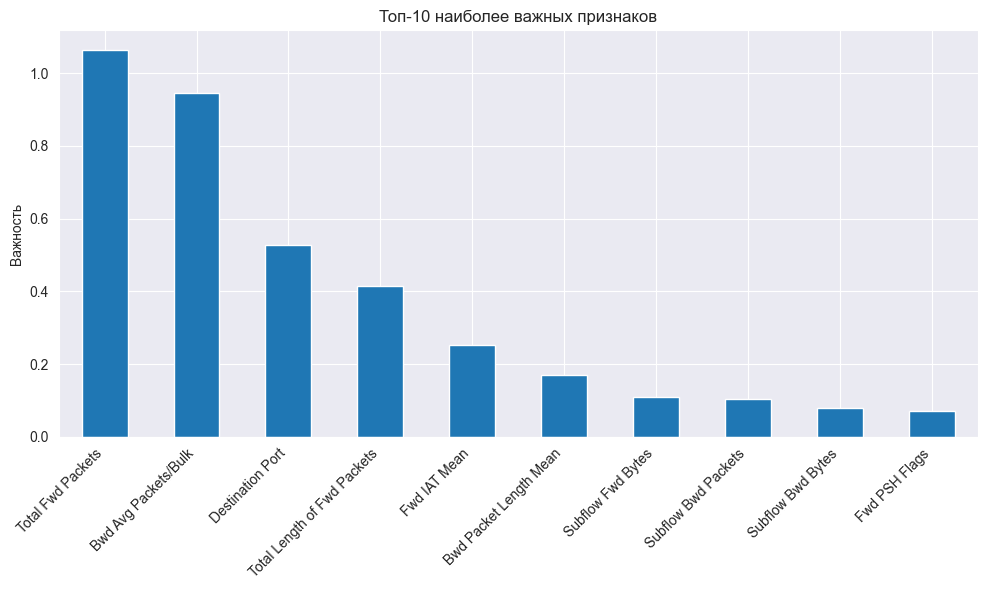

In [34]:
# Анализ важности признаков
importance = get_feature_importance(model, test_loader, device, feature_names)
print("\nВажность признаков (топ-10):")
print(importance.sort_values(ascending=False).head(10))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
importance.sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Топ-10 наиболее важных признаков')
plt.ylabel('Важность')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
model_filename = f"tabnet_{IS_BINARY }_{params.get(epochs)}.pth"
full_path = os.path.join(MODEL_PATH, model_filename)
torch.save(model.state_dict(), full_path)
print(f"Модель сохранена в {full_path}")

Модель сохранена в ./models\tabnet_dsd_10.pth



Важность признаков (топ-10):
FIN Flag Count             1.978176
Init_Win_bytes_backward    1.005928
Packet Length Variance     1.000110
Fwd Packet Length Min      1.000064
Bwd Packet Length Min      1.000054
Down/Up Ratio              0.997033
SYN Flag Count             0.986050
Avg Fwd Segment Size       0.720755
Bwd Avg Packets/Bulk       0.314290
min_seg_size_forward       0.278034
dtype: float32


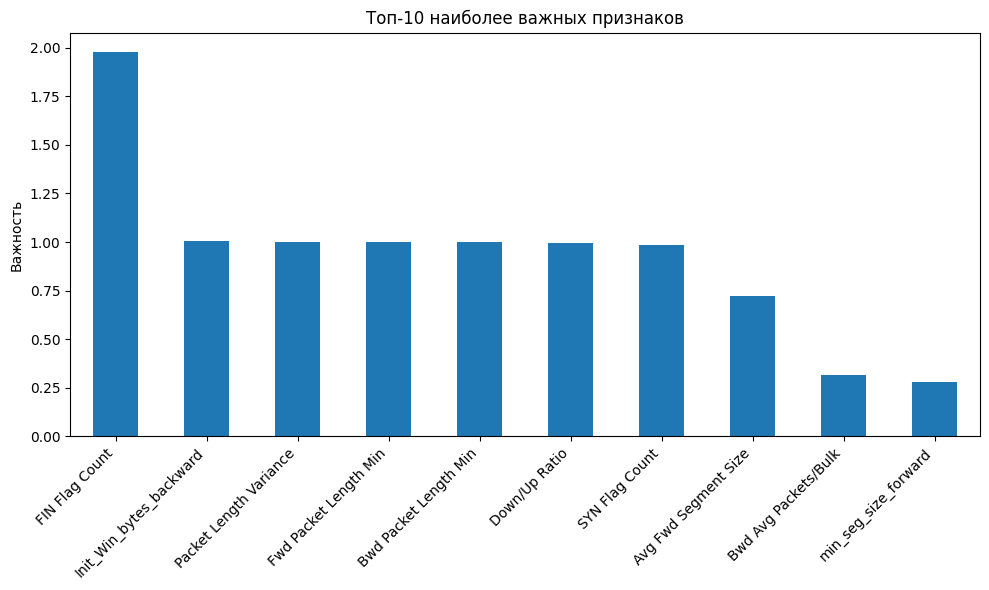